## Darts Monte-Carlo simulation
In order to calculate the probability to get a certain score, there are multiple routes, some more difficult than others.\
The most straight-forward way would be to take an image of a dart-board, generate a random xy coordinate inside the circle of the dart-board, and somehow 'read off' the randomly generated score.\
Although seemingly simple, 'reading out' the score based on the image is not so simple to implement.\
\
Instead, here we'll take a different, more abstract route.\
If we can calculate the area of each section of a dart-board, we can calculate the probability of hitting a given section on the board, and as such, also the probability to obtain a certain score with one throw.\
Based on some crude measurements of the diameters of each concentric circle on a dart-board image, we can calculate the areas of each section.\
The resulting areas are given in the following table.

Table 1. Normalised area of different sections of the dart-board.
| **Section**    | **Diameter** | **Radius** | **Circle area** | **Section area** | **Normalised area (%)** |
|----------------|--------------|------------|-----------------|------------------|-------------------------|
| Inner bullseye | 0,75         | 0,375      | 0,44            | 0,44             | 0,1019                  |
| Outer bullseye | 1,75         | 0,875      | 2,41            | 1,96             | 0,4527                  |
| Inner circle   | 10,2         | 5,1        | 81,71           | 79,31            | 18,2847                 |
| 3x ring        | 11,3         | 5,65       | 100,29          | 18,57            | 4,2825                  |
| middle circle  | 16,9         | 8,45       | 224,32          | 124,03           | 28,5957                 |
| 2x ring        | 18           | 9          | 254,47          | 30,15            | 6,9516                  |
| outer board    | 23,5         | 11,75      | 433,74          | 179,27           | 41,3309                 |


In [30]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
from datetime import timedelta

In [2]:
# test
random.choice(['a','b','c'], p=[0.2, 0.4, 0.4])

'c'

In [3]:
# make dictionary with sections and their probabilities.
sections = {
    'inner bullseye': 0.0010186,
    'outer bullseye': 0.0045269,
    'inner circle': 0.1828474,
    '3x ring': 0.0428248,
    'middle circle': 0.2859574,
    '2x ring': 0.0695156,
    'outer board': 0.4133093
}
print(sections.keys())
print(sections.values())
print(np.sum(list(sections.values())))

dict_keys(['inner bullseye', 'outer bullseye', 'inner circle', '3x ring', 'middle circle', '2x ring', 'outer board'])
dict_values([0.0010186, 0.0045269, 0.1828474, 0.0428248, 0.2859574, 0.0695156, 0.4133093])
1.0


{'inner bullseye': 10, 'outer bullseye': 36, 'inner circle': 1810, '3x ring': 404, 'middle circle': 2858, '2x ring': 698, 'outer board': 4184}


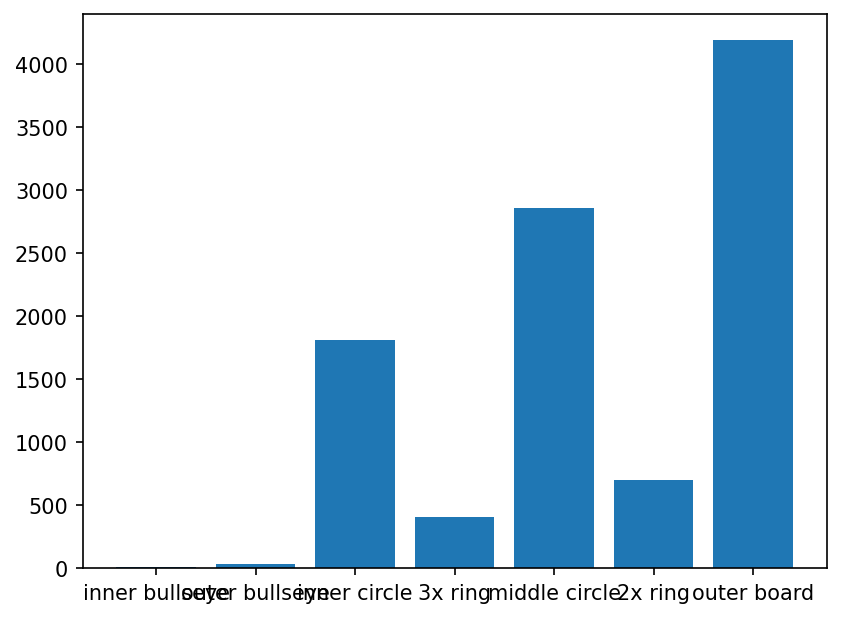

In [25]:
# Let's check if indeed, the probabilities match:
times_chosen = {
    'inner bullseye': 0,
    'outer bullseye': 0,
    'inner circle': 0,
    '3x ring': 0,
    'middle circle': 0,
    '2x ring': 0,
    'outer board': 0
}
for i in range(10000):
    times_chosen[random.choice(list(sections.keys()), p=list(sections.values()))] += 1
print(times_chosen)
# plot the result
plt.bar(list(times_chosen.keys()), times_chosen.values())
plt.show()

Since each score ranging from 1 to 20 is divided equally over the board, we can just randomly choose a number between 1 and 20 after we have obtained a random section guess, and then apply a transformation to the score if need be.

In [5]:
def throw_dart():
    double = False
    # obtain section
    section = random.choice(list(sections.keys()), p=list(sections.values()))
    # obtain value between 1 and 20
    score = random.choice(range(1,21))
    # modify score if in 'special' section
    if section == 'inner bullseye':
        score = 50
    elif section == 'outer bullseye':
        score = 25
    elif section == '3x ring':
        score *= 3
    elif section == '2x ring':
        score *= 2
        double = True
    elif section == 'outer board':
        score = 0
    # return score, and communicate if this was a double.
    return score, double

In [6]:
# Throw a dart!
throw_dart()

(13, False)

In [7]:
def play_darts(starting_score=301, print_score=False, threshold=100000):
    throws = 0
    game_score = starting_score
    double = False
    while throws < threshold:
        # throw a dart
        score, double = throw_dart()
        throws += 1
        # game finished?
        if ((game_score - score) == 0) and double:
            if print_score:
                print(f'Throw {throws}: Game end!')
            break
        # if game didn't finish, update score
        if (game_score - score) > 1:
            game_score -= score
            if print_score:
                print(f'Throw {throws}: score {game_score}')
        # note that if the previous statement is not fulfilled (ie we get a 1, 0, or negative number, or a 0 but no double), we don't update the score.
    return throws

In [8]:
# play a darts game!
play_darts()

191

With the code framework in place, let's simulate a bunch of games and calculate the average number of throws. We'll also plot a histogram with game lengths.

In [11]:
# initialise
n_throws = {}
games_played = 0
# simulate some games
for i in range(10000): # 10 000 games take 2-3 minutes to simulate.
    throws = play_darts()
    games_played += 1
    if throws not in n_throws.keys():
        n_throws[throws] = 1
    else:
        n_throws[throws] += 1

In [48]:
# bit of code to get nice time display
# taken from https://pynative.com/python-convert-seconds-to-hhmmss/#:~:text=Use%20the%20timedelta()%20constructor,%3Ass.ms%20)%20format.
def get_time_hh_mm_ss(sec):
    # create timedelta and convert it into string
    td_str = str(timedelta(seconds=sec))

    # split string into individual component
    x = td_str.split(':')
    time = '{} hours, {} minutes, {} seconds'.format(x[0], x[1], x[2])
    return time

In [49]:
# some stats!
min_throws = min(n_throws.keys())
max_throws = max(n_throws.keys())
avg_throws = np.average(list(n_throws.keys()))
std_throws = np.std(list(n_throws.keys()))
# assume 15 seconds per throw
print('Shortest game: {} throws, {}.'.format(min_throws, get_time_hh_mm_ss(min_throws*15)))
print('Longest game: {} throws, {}.'.format(max_throws, get_time_hh_mm_ss(max_throws*15)))
print('Average game length: {} throws, {}.'.format(round(avg_throws,2) , get_time_hh_mm_ss(round(avg_throws*15, 2))))
print('Standard deviation on game length: {} throws, {}.'.format(round(std_throws,2) , get_time_hh_mm_ss(round(std_throws*15, 2))))

Shortest game: 19 throws, 0 hours, 04 minutes, 45 seconds.
Longest game: 2973 throws, 12 hours, 23 minutes, 15 seconds.
Average game length: 708.02 throws, 2 hours, 57 minutes, 00.240000 seconds.
Standard deviation on game length: 463.99 throws, 1 hours, 55 minutes, 59.800000 seconds.


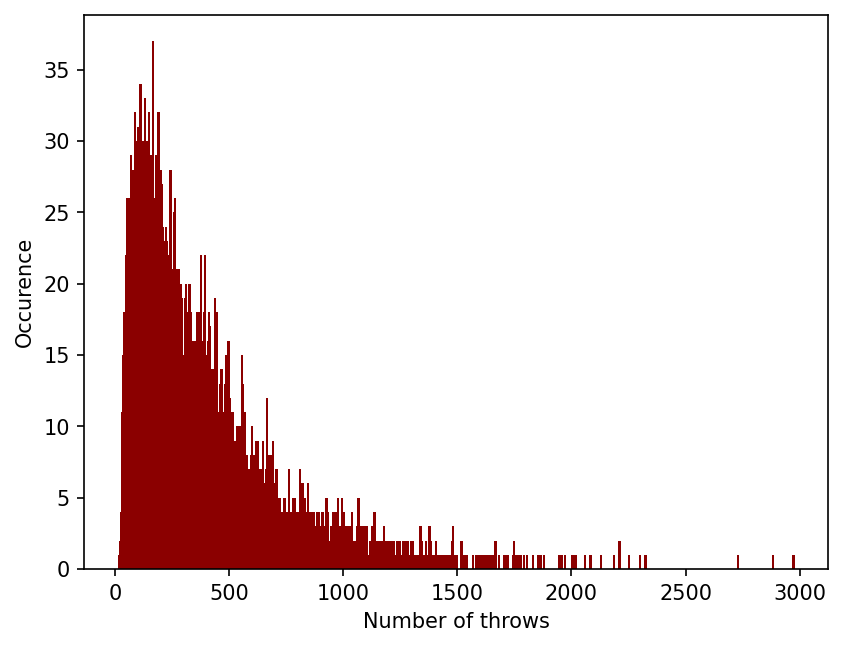

In [51]:
# plot the result
plt.bar(list(n_throws.keys()), n_throws.values(), width=10, color='darkred')
plt.xlabel('Number of throws')
plt.ylabel('Occurence')
plt.show()